In [1]:
import numpy as np
import cv2
from typing import Tuple, List, Sequence, Callable, Dict
import matplotlib.pyplot as plt
import os
import json
import torch
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import keypointrcnn_resnet50_fpn


c:\Users\OrthopedicLAB\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True,
    bbox: np.ndarray = None,
    color: Tuple[int, int, int] = None,
    dpi: int = 200,
    file_name: str = None
) -> None:
    """
        image : np.ndarray
        keypoints : np.ndarray
        edges : List[Tuple(int, int)]
        keypoint_names : Dict[int, str]
        boxes : bool
        color : Tuple(int, int, int)
        dpi : int
        file_name : str

        이미지에 keypoints와 boundary box 에 해당하는 부분을 그려 시각화시키는 함수입니다.
        color은 원하는 색상으로 레이블을 표현할 경우에 사용됩니다.
        boxes는 boundary box를 표현하고 싶을 때 사용됩니다. (default = False)
        keypoint_names은 각각 keypoint들에 이름을 표현하고 싶을 때 사용됩니다.
        edges는 각 keypoints들에서 연결이 필요한 경우 두 점을 이어주는 선을 그리는데 사용됩니다.
    """
    np.random.seed(42)
    if color: # 색을 따로 지정해두지 않았을 경우
        colors = color
        if (boxes == True) & (bbox is not None):
            color_bbox = 0 # 0 Femoral -> (124,252,0) | 1 Tibial -> (149, 53, 83)
            for bbox_ in bbox:
                x1, y1 = int(bbox_[0]), int(bbox_[1])
                x2, y2 = int(bbox_[2]), int(bbox_[3])
                
                if color_bbox == 0:
                    cv2.rectangle(image, (x1, y1), (x2, y2), colors, thickness=30)
                    color_bbox += 1
                elif color_bbox == 1:
                    cv2.rectangle(image, (x1, y1), (x2, y2), colors, thickness=30)

        for i, keypoint in enumerate(keypoints):
            keypoint = [p[:2].astype(int) for p in keypoint]
            for point in keypoint:
                cv2.circle(
                    image, 
                    tuple(point), 
                    3, colors, thickness=int(image.shape[0]*0.005), lineType=cv2.FILLED) 

            if keypoint_names is not None:
                cv2.putText(
                    image, 
                    f'{i}: {keypoint_names[i]}', 
                    tuple(point), 
                    cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 1) # 0.5 000

        if edges is not None:
            keypoints = [*keypoints[0] , *keypoints[1]]
            keypoints = [p[:2].astype(int) for p in keypoints]
            for i, edge in enumerate(edges):
                cv2.line(
                    image, 
                    tuple(keypoints[edge[0]]),
                    tuple(keypoints[edge[1]]),
                    colors, thickness=int(image.shape[0]*0.002), lineType=cv2.LINE_AA)

    else:
        colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(4)} # len(keypoint_names)
        # color_femoral = (124, 252, 0)
        # color_tibial = (149, 53, 83)
    
        if (boxes == True) & (bbox is not None):
            color_bbox = 0 # 0 Femoral -> (124,252,0) | 1 Tibial -> (149, 53, 83)
            for bbox_ in bbox:
                x1, y1 = int(bbox_[0]), int(bbox_[1])
                x2, y2 = int(bbox_[2]), int(bbox_[3])
                
                if color_bbox == 0:
                    cv2.rectangle(image, (x1, y1), (x2, y2), (124, 252, 0), thickness=30)
                    color_bbox += 1
                elif color_bbox == 1:
                    cv2.rectangle(image, (x1, y1), (x2, y2), (149, 53, 83), thickness=30)

        for i, keypoint in enumerate(keypoints):
            keypoint = [p[:2].astype(int) for p in keypoint]
            for point in keypoint:
                cv2.circle(
                    image, 
                    tuple(point), 
                    3, colors.get(i), thickness=int(image.shape[0]*0.005), lineType=cv2.FILLED) 

            if keypoint_names is not None:
                cv2.putText(
                    image, 
                    f'{i}: {keypoint_names[i]}', 
                    tuple(point), 
                    cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 1) # 0.5 000

        if edges is not None:
            keypoints = [*keypoints[0] , *keypoints[1]]
            keypoints = [p[:2].astype(int) for p in keypoints]
            for i, edge in enumerate(edges):
                cv2.line(
                    image, 
                    tuple(keypoints[edge[0]]),
                    tuple(keypoints[edge[1]]),
                    colors.get(edge[0]), thickness=int(image.shape[0]*0.002), lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    if file_name is None:  # set file name
        fig.savefig('example.png')
    else:
        file_name = file_name.replace('.jpg','')
        fig.savefig(f'label_{file_name}.png')

In [3]:
def get_model(num_keypoints, num_objects, weights_path=None):
    '''
    num_objects : int   | number of objects that you want to detect
    num_keypoints : int | number of keypoints that you are interested in object
    '''
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = keypointrcnn_resnet50_fpn(
                                    # weights=False,            # Is deprecated since 0.13, default = None (Annotated cause it occurs warnings)
                                    # weights_backbone=True,    # Is deprecated since 0.13, default = ResNet50_Weights.IMAGENET1K_V1 (Annotated cause it occurs warnings)
                                    num_keypoints=num_keypoints,
                                    num_classes=num_objects,    # Background is the first class, objects are other classes
                                    rpn_anchor_generator=anchor_generator
                                )
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [4]:
# 이미지를 테스트할 때 사용할 weight 파일과 이미지 파일을 선택하기 위해 어떤 파일들이 폴더에 있는지 확인합니다.
weight_list = os.listdir('./weights')
print("weight files list that you can choose : \n", weight_list)
print("\n")
image_list = os.listdir('./images')
print("image files list that you can choose : \n", image_list)

weight files list that you can choose : 
 ['xray_rcnnkeypoints_weights_01.pth', 'xray_rcnnkeypoints_weights_exp02.pth']


image files list that you can choose : 
 ['1-00744541L.jpg', '1-00744541R.jpg', '10-02287852L.jpg', '10-02287852R.jpg', '100-02454820L.jpg', '100-02454820R.jpg', '101-02014179L.jpg', '101-02014179R.jpg', '102-00389969L.jpg', '102-00389969R.jpg', '103-02299812L.jpg', '103-02299812R.jpg', '104-00453374L.jpg', '104-00453374R.jpg', '105-00765897L.jpg', '105-00765897R.jpg', '106-01035918L.jpg', '106-01035918R.jpg', '107-00542154L.jpg', '107-00542154R.jpg', '108-02162453L.jpg', '108-02162453R.jpg', '109-02238889L.jpg', '109-02238889R.jpg', '11-01026682L.jpg', '11-01026682R.jpg', '110-02292924L.jpg', '110-02292924R.jpg', '111-00608502L.jpg', '111-00608502R.jpg', '112-01001099L.jpg', '112-01001099R.jpg', '113-00864610L.jpg', '113-00864610R.jpg', '114-00656267L.jpg', '114-00656267R.jpg', '115-00796102L.jpg', '115-00796102R.jpg', '116-00258692L.jpg', '116-00258692R.jpg', '117

In [5]:
# 확인하고자 하는 이미지를 로드합니다.
model_path = './weights'
model_name = 'xray_rcnnkeypoints_weights_exp02.pth'
# image_path = './images/10-02287852R.jpg'
image_path = './images'
# image_name = '19-00325701R.jpg'
image_name = '13-00900143L.jpg'

image = cv2.imread(os.path.join(image_path, image_name))
image = image / 255
image = image.transpose(2,0,1)
print(image.shape)
image = [torch.as_tensor(image, dtype=torch.float32)]

# 이미지에 대해 keypoints detection를 진행할 weight file 을 로드합니다.
# Prediction
model = get_model(num_keypoints=2, num_objects=3)  # num_objects -> 3
model.load_state_dict(torch.load(os.path.join(model_path, model_name)))
model.eval()
preds = model(image)
keypoints = preds[0]['keypoints'].detach().numpy().copy()

print(keypoints)

(3, 9000, 9000)
[[[4.5801743e+03 5.4301929e+03 1.0000000e+00]
  [4.6139136e+03 8.3165059e+03 1.0000000e+00]]

 [[4.5295693e+03 1.4463468e+03 1.0000000e+00]
  [4.6079399e+03 5.2199756e+03 1.0000000e+00]]

 [[4.5453740e+03 1.3144299e+03 1.0000000e+00]
  [4.5901694e+03 5.2580156e+03 1.0000000e+00]]

 [[4.5796260e+03 1.3493474e+03 1.0000000e+00]
  [4.5572705e+03 1.3941390e+03 1.0000000e+00]]

 [[4.6202915e+03 8.9857803e+03 1.0000000e+00]
  [3.8168750e+03 8.9952598e+03 1.0000000e+00]]

 [[4.5760938e+03 5.4301714e+03 1.0000000e+00]
  [4.6208130e+03 8.3063242e+03 1.0000000e+00]]

 [[4.6609458e+03 8.9781748e+03 1.0000000e+00]
  [4.1868193e+03 8.9956348e+03 1.0000000e+00]]

 [[3.8061399e+03 8.9951924e+03 1.0000000e+00]
  [3.8061399e+03 8.9951924e+03 1.0000000e+00]]

 [[4.5269761e+03 1.4676538e+03 1.0000000e+00]
  [4.5491270e+03 4.9311665e+03 1.0000000e+00]]

 [[4.5470786e+03 1.4372979e+03 1.0000000e+00]
  [4.7471592e+03 3.7882336e+03 1.0000000e+00]]]


In [6]:
# 이미지에서 keypoints 탐지를 진행하면 여러개의 결과값이 나오게 됩니다.
# 각 결과값에서 score 가 높은 객체와 keypoints들만 선정하여 활용합니다. (정확도가 0.9 이상인 경우만)

# dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])
print("number of detected objects : ", len(preds[0]))
print("prediction scores of detected objects : ",preds[0]['scores'])

predicts = []

for idx, score in enumerate(preds[0]['scores']):
    if score > 0.9: # 정확도가 0.9 이상일 경우 해당 예측치만 모두 append
        predicts.append({
            'boxes':preds[0]['boxes'][idx],
            'labels':preds[0]['labels'][idx],
            'scores':preds[0]['scores'][idx],
            'keypoints':preds[0]['keypoints'][idx],
            'keypoints_scores':preds[0]['keypoints_scores'][idx],
        })
        print(preds[0]['labels'][idx])

print("\npredict keys : ", predicts[0].keys())
print("\nprediction [0] : ", predicts[0])

number of detected objects :  5
prediction scores of detected objects :  tensor([0.9830, 0.9684, 0.3087, 0.1910, 0.1392, 0.1117, 0.1023, 0.0915, 0.0904,
        0.0755], grad_fn=<IndexBackward0>)
tensor(2)
tensor(1)

predict keys :  dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

prediction [0] :  {'boxes': tensor([4180.9204, 5132.5771, 4934.4414, 8501.8145], grad_fn=<SelectBackward0>), 'labels': tensor(2), 'scores': tensor(0.9830, grad_fn=<SelectBackward0>), 'keypoints': tensor([[4.5802e+03, 5.4302e+03, 1.0000e+00],
        [4.6139e+03, 8.3165e+03, 1.0000e+00]], grad_fn=<SelectBackward0>), 'keypoints_scores': tensor([21.5264, 25.5491], grad_fn=<SelectBackward0>)}


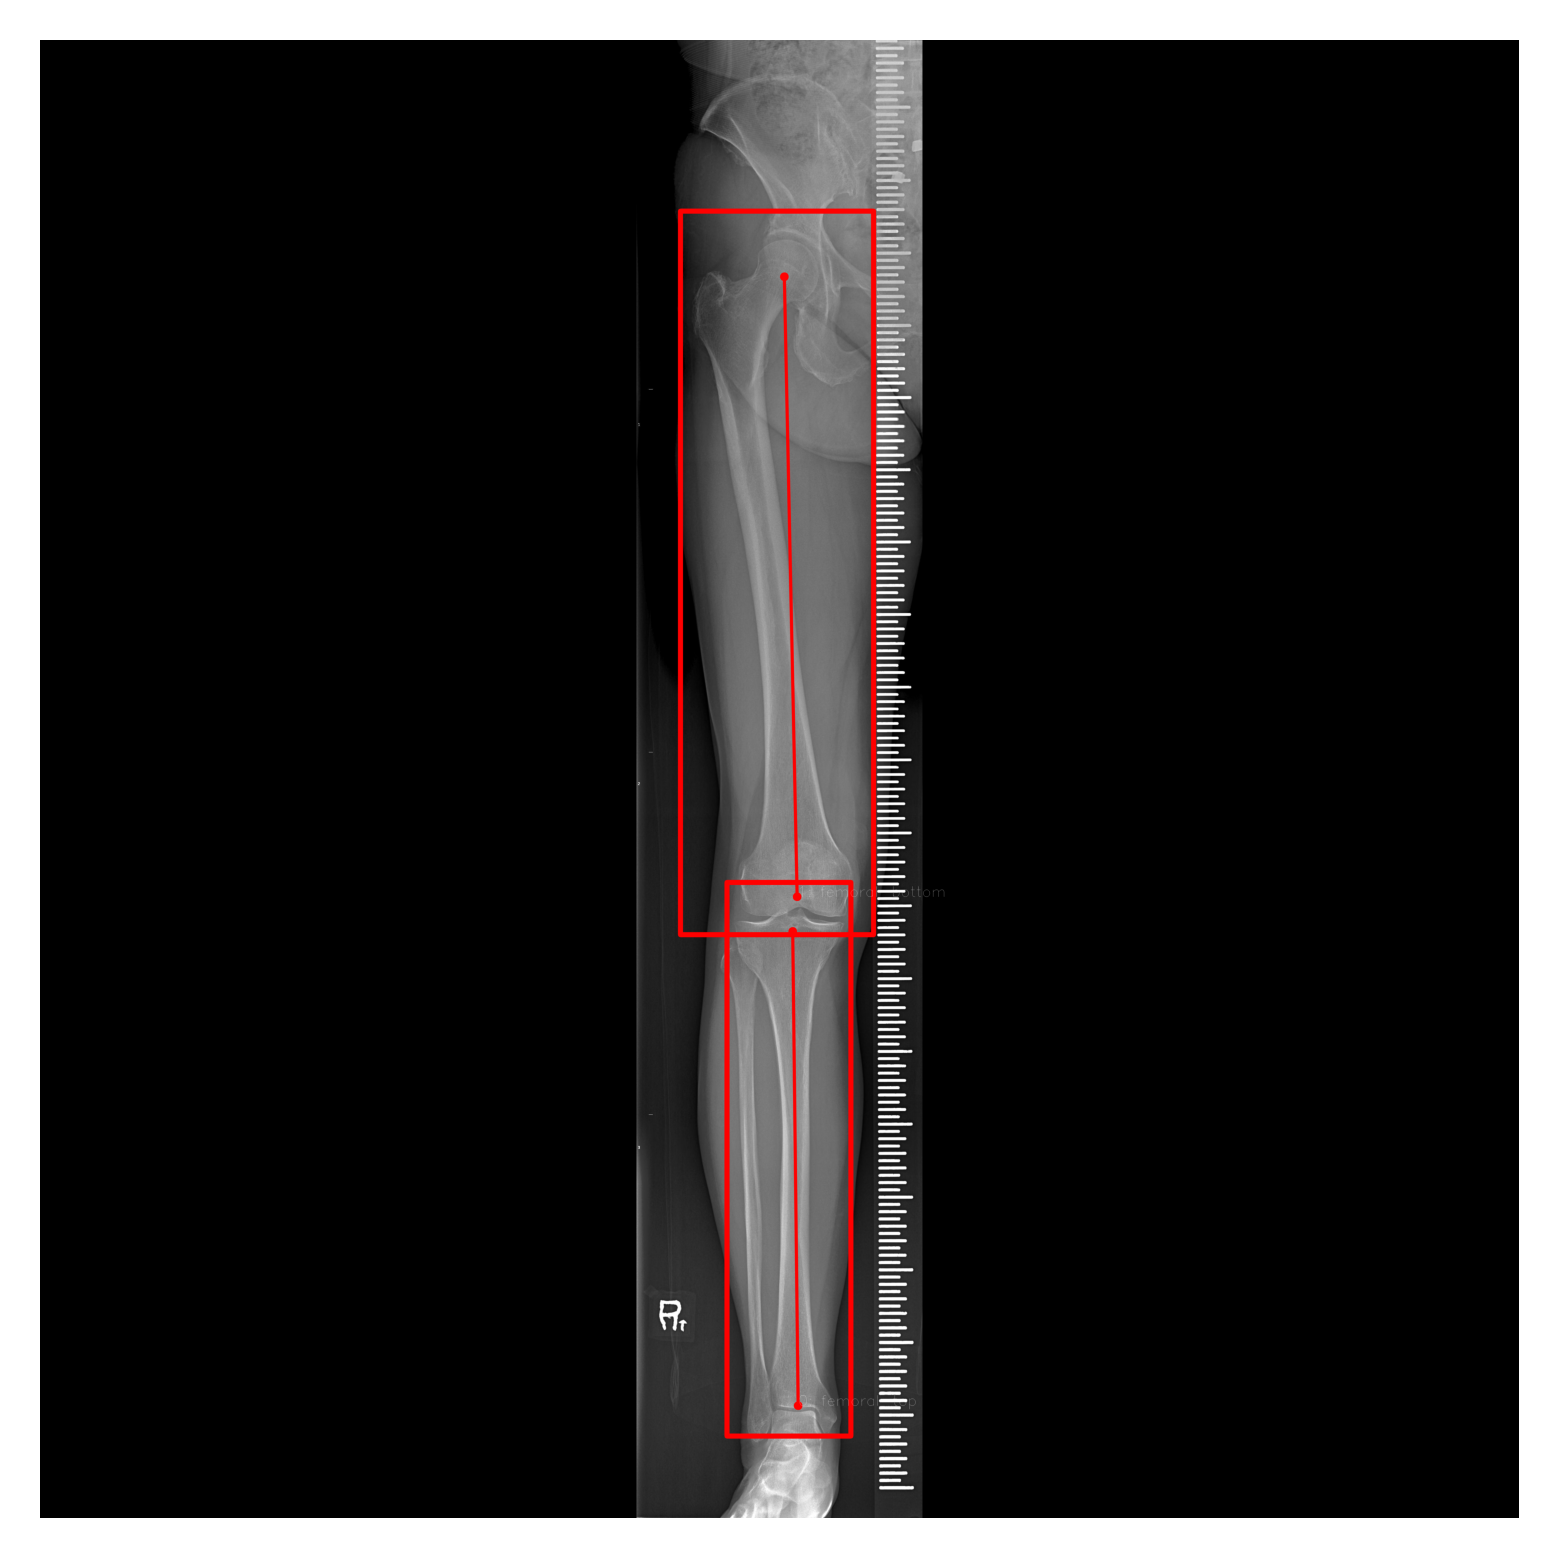

In [7]:
# keypoints 탐지 결과를 시각화합니다.
keypoints = [predict['keypoints'].detach().numpy().copy() for predict in predicts]
bboxes = [predict['boxes'].detach().numpy().copy() for predict in predicts]

for bbox in bboxes:
    bbox = np.array(bbox)
    bbox = bbox.astype(np.int64)
keypoint_names = {
    0: 'femoral-top',
    1: 'femoral-bottom',
    2: 'tibial-top',
    3: 'tibial-bottom'
}

edges = [
    (0, 1), (2, 3)
]

file_name='exampleee.png'
draw_keypoints(image, keypoints, edges, keypoint_names, boxes=True, bbox=bboxes, dpi=400, color=(255,0,0), file_name=file_name)

Prediction is red color


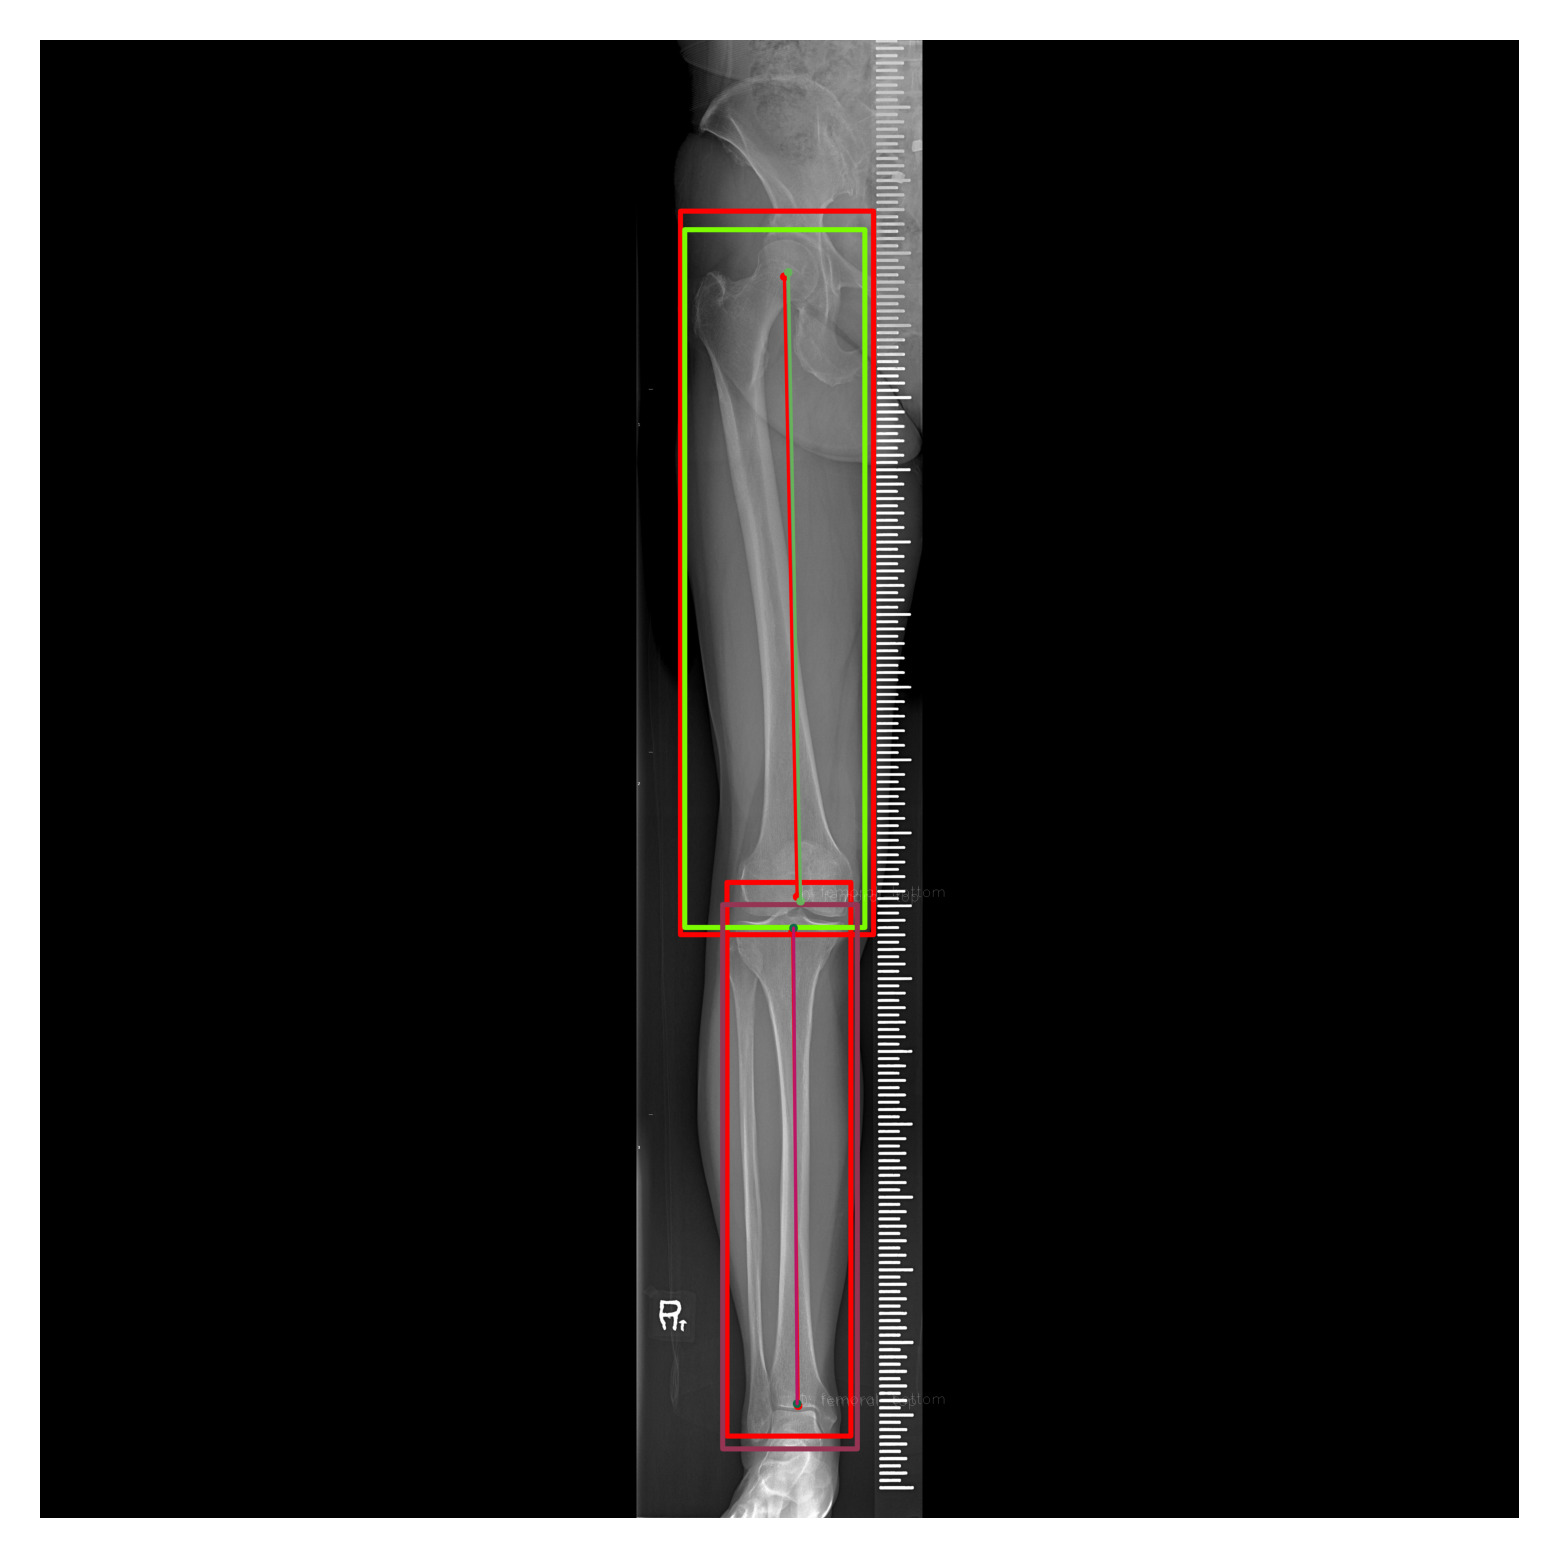

In [9]:
# 실제 레이블을 시각화하여 예측된 값들이 얼마나 실제를 잘 반영하는지 비교합니다.
label_path = './annotations'
label_id = image_name.replace('.jpg', '') + '.json'

with open(os.path.join(label_path, label_id)) as f:
    label_data = json.load(f)
    annotated_bboxes = np.array([np.array(bbox).astype(np.int32) for bbox in label_data['bboxes']])
    annotated_keypoints = np.array(label_data['keypoints'])
    
print("Prediction is red color")
draw_keypoints(image, annotated_keypoints, edges, keypoint_names, boxes=True, bbox=annotated_bboxes, dpi=400, file_name=file_name)

In [ ]:
# keypoints들을 통해서 각각 femoral와 tibial에 해당하는 부분들을 구성하여 원하는 정보를 출력합니다.
# femoral과 tibial이 이루는 HKA(Hip-Knee-Ankle), femoral과 tibial의 각 길이 등
# 모델에서 예측한 keypoints들과 실제 레이블링 되었던 keypoints들을 비교합니다.
pixel_spacing = 0.0117918794067591  #  실제 픽셀값과 사진에 나온 자를 통해서 각 픽셀이 실측치로 얼마인지 계산합니다. (정확한 값은 아닙니다.)

annotated_femoral_axis = np.array(annotated_keypoints[0][1][:2]) - np.array(annotated_keypoints[0][0][:2])
annotated_tibial_axis = np.array(annotated_keypoints[1][1][:2]) - np.array(annotated_keypoints[1][0][:2])
annotated_femoral_range = np.linalg.norm(np.array(annotated_keypoints[0][1][:2]) - np.array(annotated_keypoints[0][0][:2])) * pixel_spacing
annotated_tibial_range = np.linalg.norm(np.array(annotated_keypoints[1][1][:2]) - np.array(annotated_keypoints[1][0][:2])) * pixel_spacing
annotated_angle = np.arctan2(annotated_femoral_axis[1], annotated_femoral_axis[0]) - np.arctan2(annotated_tibial_axis[1], annotated_tibial_axis[0])
print("The annotated femoral axis is : ", annotated_femoral_axis)
print("The annotated tibial axis is : ", annotated_tibial_axis)
print("The annotated femoral range is : ", annotated_femoral_range)
print("The annotated tibial range is : ", annotated_tibial_range)
print("The annotated HKA(Hip-Knee-Ankle) angle is : ", np.degrees(annotated_angle)) # np.degrees -> radian 값을 degree 값으로 변환


for idx, label in enumerate(predicts):
    if label['labels'] == 1: # femoral
        predicted_femoral_axis = np.array(keypoints[idx][1][:2]) - np.array(keypoints[idx][0][:2])
        predicted_femoral_range = np.linalg.norm(np.array(keypoints[idx][1][:2]) - np.array(keypoints[idx][0][:2])) * pixel_spacing
    elif label['labels'] == 2: # tibial
        predicted_tibial_axis = np.array(keypoints[idx][1][:2]) - np.array(keypoints[idx][0][:2])
        predicted_tibial_range = np.linalg.norm(np.array(keypoints[idx][1][:2]) - np.array(keypoints[idx][0][:2])) * pixel_spacing
    else:
        print('error')
predicted_angle = np.arctan2(predicted_femoral_axis[1], predicted_femoral_axis[0]) - np.arctan2(predicted_tibial_axis[1], predicted_tibial_axis[0]) # for right side of legs
print("\nThe predicted femoral axis is : ", predicted_femoral_axis)
print("The predicted tibial axis is : ", predicted_tibial_axis)
print("The predicted femoral range is : ", predicted_femoral_range)
print("The predicted tibial range is : ", predicted_tibial_range)
print("The prediction of HKA(Hip-Knee-Ankle) angle is : ", np.degrees(predicted_angle))